# YOGA poses classification using Convolutional Neural Network (CNN)

## Importing libraries

In [4]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

## Importing Data

In [5]:
from os import walk
for (dirpath, dirnames, filenames) in walk("D:/datayoga"):
    print("Directory path: ", dirpath)

Directory path:  D:/datayoga
Directory path:  D:/datayoga\TEST
Directory path:  D:/datayoga\TEST\downdog
Directory path:  D:/datayoga\TEST\goddess
Directory path:  D:/datayoga\TEST\plank
Directory path:  D:/datayoga\TEST\tree
Directory path:  D:/datayoga\TEST\warrior2
Directory path:  D:/datayoga\TRAIN
Directory path:  D:/datayoga\TRAIN\downdog
Directory path:  D:/datayoga\TRAIN\goddess
Directory path:  D:/datayoga\TRAIN\plank
Directory path:  D:/datayoga\TRAIN\tree
Directory path:  D:/datayoga\TRAIN\warrior2


## Data Preparation

### Data Preprocessing

removing corrupted images

In [6]:
def removeCorruptedImages(dataset_directory):
    for directory in os.listdir(dataset_directory):
        for img in os.listdir(os.path.join(dataset_directory, directory)):
            img_path = os.path.join(dataset_directory, directory, img)
            try:
                cv2.imread(img_path)
            except:
                os.remove(img_path)

In [9]:
train_dataset_directory = 'D:/datayoga/TRAIN'
test_dataset_directory = 'D:/datayoga/TEST'

In [10]:
removeCorruptedImages(train_dataset_directory)

In [ ]:
removeCorruptedImages(test_dataset_directory)

### Data Exploration

In [11]:
classes = os.listdir(train_dataset_directory)
classes

['downdog', 'goddess', 'plank', 'tree', 'warrior2']

In [12]:
def dataset_distribution(dataset_directory, title):
    nbr_imgs_per_class = []
    for directory in os.listdir(dataset_directory):
        nbr_imgs_per_class.append(len(os.listdir(os.path.join(dataset_directory, directory))))
    dataset_distribution = [nbr/sum(nbr_imgs_per_class)*100 for nbr in nbr_imgs_per_class]
    fix, ax = plt .subplots(figsize=(16, 8))
    plt.title(title)
    ax.pie(dataset_distribution, labels=classes, autopct='%1.1f%%', shadow=True, explode = (0.05, 0.05, 0.05, 0.05, 0.05))

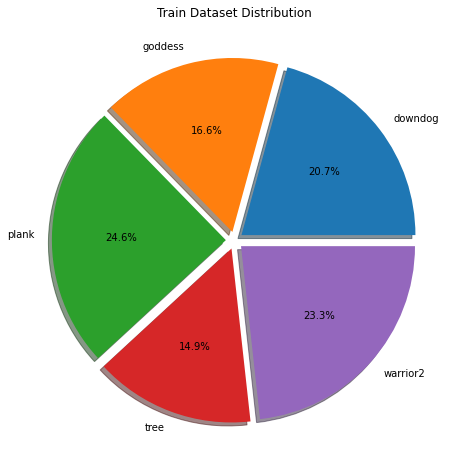

In [13]:
dataset_distribution(train_dataset_directory, 'Train Dataset Distribution')

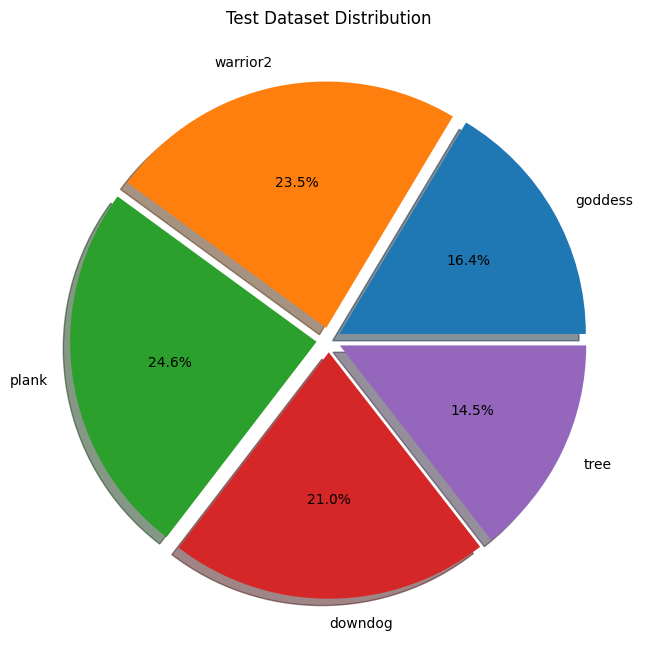

In [ ]:
dataset_distribution(test_dataset_directory, 'Test Dataset Distribution')

***The data is balanaced (No imbalanced data problem)***

### Load Data

In [14]:
IMG_SIZE = 256

In [15]:
X_train = []
y_train = []

for i, category in enumerate(classes):
    for img in os.listdir(os.path.join(train_dataset_directory, category)):
        img_path = os.path.join(train_dataset_directory, category, img)
        X_train.append(cv2.resize(cv2.imread(img_path), (IMG_SIZE , IMG_SIZE)))
        y_train.append(i)
X_train = np.asarray(X_train)
y_train = pd.get_dummies(y_train).values

In [16]:
X_train.shape

(1075, 256, 256, 3)

In [17]:
X_test = []
y_test = []

for i, category in enumerate(classes):
    for img in os.listdir(os.path.join(test_dataset_directory, category)):
        img_path = os.path.join(test_dataset_directory, category, img)
        X_test.append(cv2.resize(cv2.imread(img_path), (IMG_SIZE , IMG_SIZE)))
        y_test.append(i)
X_test = np.asarray(X_test)
y_test = pd.get_dummies(y_test).values

In [18]:
X_test.shape

(466, 256, 256, 3)

### Scaling Data

In [19]:
X_train = X_train/255.0
X_test = X_test/255.0

### Split Data

In [21]:
SPLIT_SIZE = 0.2

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = SPLIT_SIZE,
    random_state = 42)

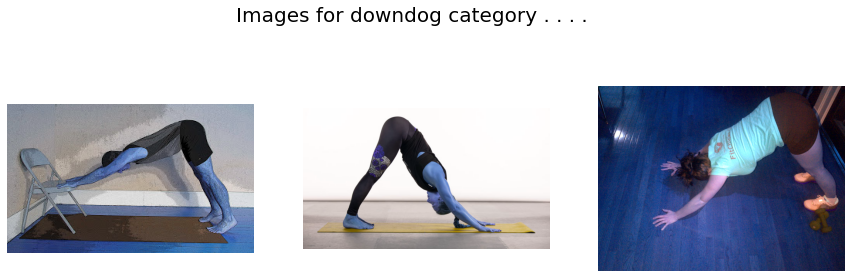

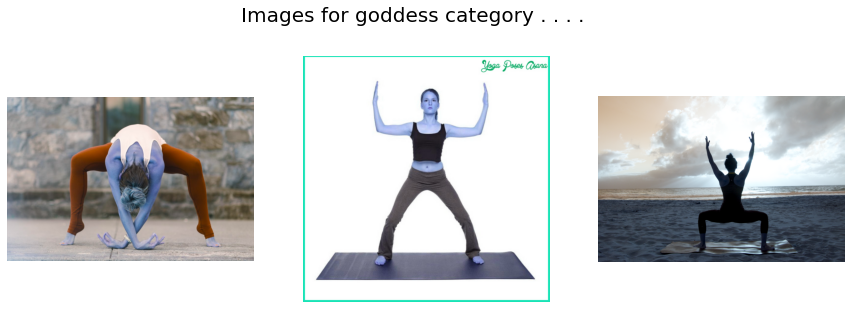

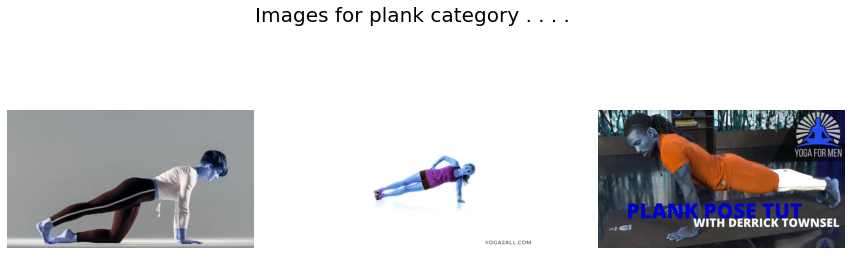

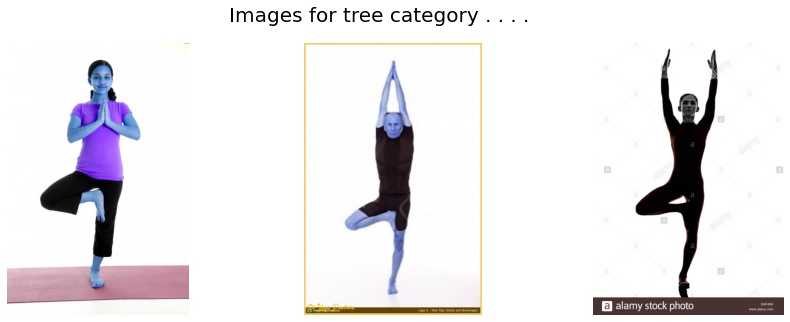

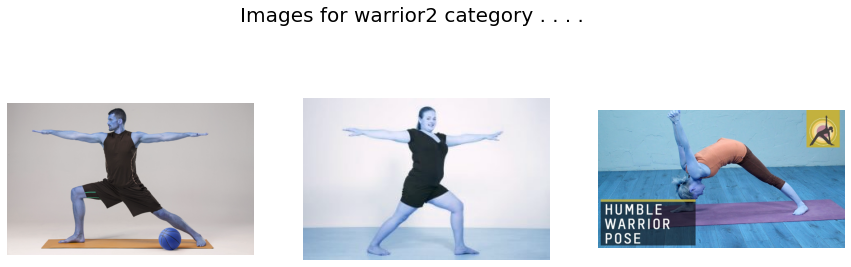

In [23]:
for category in classes:
    images = os.listdir(os.path.join(train_dataset_directory, category))
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {category} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img_path = os.path.join(train_dataset_directory, category, images[k])
        img = np.array(cv2.imread(img_path))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

## Modeling

### Build the model

In [24]:
model1 = Sequential()

model1.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model1.add(MaxPooling2D())

model1.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model1.add(MaxPooling2D())

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))

model1.add(Dense(5, activation='softmax'))

In [25]:
model1.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

## Training

In [27]:
# hyperparameters
EPOCHS = 10
BATCH_SIZE = 8

In [28]:
history1 = model1.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/10
108/108 [==============================] - 42s 278ms/step - loss: 2.1732 - accuracy: 0.2663 - val_loss: 1.4368 - val_accuracy: 0.4884
Epoch 2/10
108/108 [==============================] - 29s 271ms/step - loss: 0.9787 - accuracy: 0.6895 - val_loss: 1.1575 - val_accuracy: 0.6000
Epoch 3/10
108/108 [==============================] - 29s 265ms/step - loss: 0.4395 - accuracy: 0.8779 - val_loss: 1.0935 - val_accuracy: 0.6791
Epoch 4/10
108/108 [==============================] - 28s 263ms/step - loss: 0.1308 - accuracy: 0.9698 - val_loss: 1.3972 - val_accuracy: 0.6558
Epoch 5/10
108/108 [==============================] - 31s 284ms/step - loss: 0.0395 - accuracy: 0.9953 - val_loss: 1.7242 - val_accuracy: 0.6233
Epoch 6/10
108/108 [==============================] - 32s 295ms/step - loss: 0.0200 - accuracy: 0.9977 - val_loss: 1.6628 - val_accuracy: 0.6465
Epoch 7/10
108/108 [==============================] - 30s 274ms/step - loss: 0.0148 - accuracy: 0.9977 - val_loss: 1.6197 - val_ac

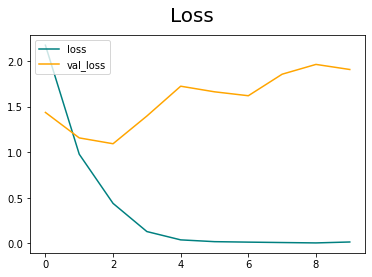

In [29]:
fig = plt.figure()

plt.plot(history1.history['loss'], color='teal', label='loss')
plt.plot(history1.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

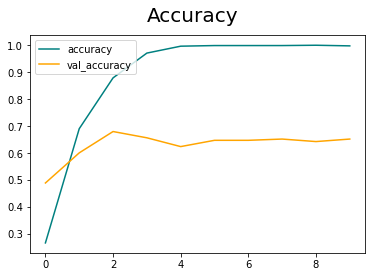

In [30]:
fig = plt.figure()

plt.plot(history1.history['accuracy'], color='teal', label='accuracy')
plt.plot(history1.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

***The validation loss is increasing, in contrast training loss is decreasing (training accuracy is increasing ), this indicates that our model is overfitting to the training data. In other words, the model is performing well on the training data, but it is not able to generalize well to new, unseen data.(validation data)***

In [31]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95:
            print('\n Validation accuracy = \
            95% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=3,
                       factor=0.5,
                       verbose=1)

In [32]:
model2 = Sequential()

model2.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model2.add(MaxPooling2D())

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [33]:
model2.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history2 = model2.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [es, lr, myCallback()]
)

Epoch 1/10
108/108 [==============================] - 40s 355ms/step - loss: 1.7120 - accuracy: 0.3105 - val_loss: 1.5027 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 37s 345ms/step - loss: 1.0567 - accuracy: 0.6140 - val_loss: 1.0808 - val_accuracy: 0.5860 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 35s 326ms/step - loss: 0.5088 - accuracy: 0.8233 - val_loss: 1.1399 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 4/10
108/108 [==============================] - 36s 335ms/step - loss: 0.1958 - accuracy: 0.9395 - val_loss: 1.8148 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 5/10
108/108 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9767
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 [==============================] - 35s 324ms/step - loss: 0.0764 - accuracy: 0.9767 - val_loss: 1.7383 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 6/10
108/108 [=============================

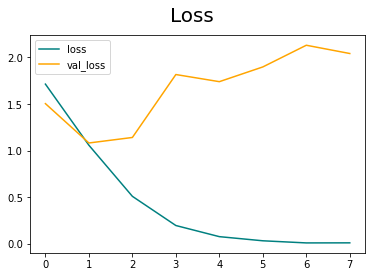

In [35]:
fig = plt.figure()

plt.plot(history2.history['loss'], color='teal', label='loss')
plt.plot(history2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

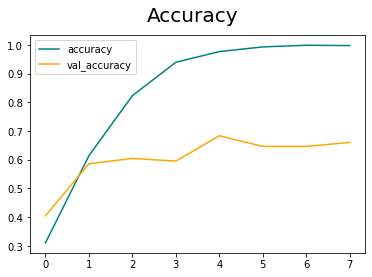

In [36]:
fig = plt.figure()

plt.plot(history2.history['accuracy'], color='teal', label='accuracy')
plt.plot(history2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

***Better Validation Accuracy but the overfitting problem still exist. Maybe we need more regularization !***

In [37]:
model3 = Sequential()

model3.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model3.add(Dropout(0.1))
model3.add(MaxPooling2D())

model3.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model3.add(Dropout(0.1))
model3.add(MaxPooling2D())

model3.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model3.add(Dropout(0.1))
model3.add(MaxPooling2D())

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

In [38]:
model3.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
history3 = model3.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [es, lr, myCallback()]
)

Epoch 1/10
108/108 [==============================] - 84s 395ms/step - loss: 1.7318 - accuracy: 0.3058 - val_loss: 1.4076 - val_accuracy: 0.4744 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 38s 357ms/step - loss: 1.2301 - accuracy: 0.5512 - val_loss: 1.0552 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 37s 342ms/step - loss: 0.7986 - accuracy: 0.7174 - val_loss: 0.9364 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 4/10
108/108 [==============================] - 40s 368ms/step - loss: 0.4214 - accuracy: 0.8570 - val_loss: 0.9029 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 5/10
108/108 [==============================] - 40s 366ms/step - loss: 0.2166 - accuracy: 0.9244 - val_loss: 0.9035 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 6/10
108/108 [==============================] - 40s 369ms/step - loss: 0.1342 - accuracy: 0.9628 - val_loss: 1.0079 - val_accuracy: 0.7209 - lr: 0.0010
Epoch 7/10
108/108 [==============================] 

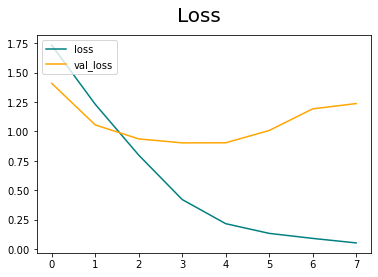

In [41]:
fig = plt.figure()

plt.plot(history3.history['loss'], color='teal', label='loss')
plt.plot(history3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

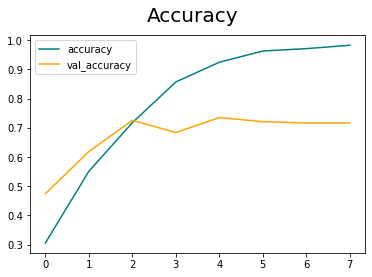

In [42]:
fig = plt.figure()

plt.plot(history3.history['accuracy'], color='teal', label='accuracy')
plt.plot(history3.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

***The validation accucracy got better. But the overfitting problem still exist. we think we need more regularization!***

In [43]:
model4 = Sequential()

model4.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model4.add(Dropout(0.3))
model4.add(BatchNormalization())
model4.add(MaxPooling2D())

model4.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model4.add(Dropout(0.3))
model4.add(BatchNormalization())
model4.add(MaxPooling2D())

model4.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model4.add(Dropout(0.3))
model4.add(BatchNormalization())
model4.add(MaxPooling2D())

model4.add(Flatten())

model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.3))
model4.add(BatchNormalization())
model4.add(Dense(5, activation='softmax'))

In [44]:
model4.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history4 = model4.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [es, lr, myCallback()]
)

Epoch 1/10
108/108 [==============================] - 48s 448ms/step - loss: 1.3900 - accuracy: 0.4430 - val_loss: 2.9841 - val_accuracy: 0.1953 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 53s 487ms/step - loss: 1.1750 - accuracy: 0.5535 - val_loss: 5.5551 - val_accuracy: 0.2698 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 51s 473ms/step - loss: 1.0971 - accuracy: 0.5907 - val_loss: 6.8279 - val_accuracy: 0.2837 - lr: 0.0010
Epoch 4/10
108/108 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.5640
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 [==============================] - 47s 436ms/step - loss: 1.0815 - accuracy: 0.5640 - val_loss: 4.5488 - val_accuracy: 0.2698 - lr: 0.0010
Epoch 5/10
108/108 [==============================] - 47s 435ms/step - loss: 1.0410 - accuracy: 0.6058 - val_loss: 6.4040 - val_accuracy: 0.2372 - lr: 5.0000e-04
Epoch 6/10
108/108 [=========================

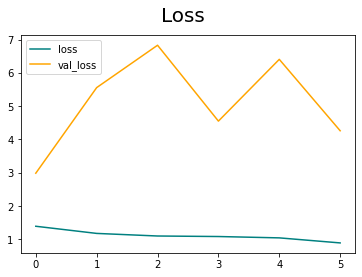

In [47]:
fig = plt.figure()

plt.plot(history4.history['loss'], color='teal', label='loss')
plt.plot(history4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

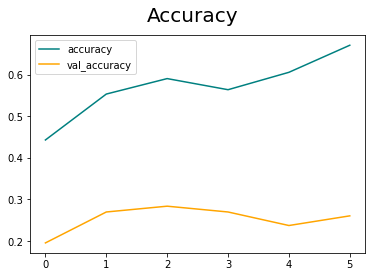

In [48]:
fig = plt.figure()

plt.plot(history4.history['accuracy'], color='teal', label='accuracy')
plt.plot(history4.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

***Seems like BatchNomalization made things worse. We should move it from our model***

In [49]:
model5 = Sequential()

model5.add(Conv2D(8, (3,3), padding='same', activation='relu', kernel_regularizer='l2', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model5.add(Dropout(0.3))
model5.add(MaxPooling2D((2,2)))

model5.add(Conv2D(16, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
model5.add(Dropout(0.3))
model5.add(MaxPooling2D((2,2)))

model5.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
model5.add(Dropout(0.3))
model5.add(MaxPooling2D((2,2)))

model5.add(Flatten())

model5.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model5.add(Dropout(0.3))
model5.add(Dense(5, activation='softmax'))

In [50]:
model5.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
history5 = model5.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = 20,
    callbacks = [es, lr, myCallback()]
)

Epoch 1/20
108/108 [==============================] - 50s 349ms/step - loss: 3.0198 - accuracy: 0.2593 - val_loss: 1.9538 - val_accuracy: 0.3581 - lr: 0.0010
Epoch 2/20
108/108 [==============================] - 40s 366ms/step - loss: 1.8530 - accuracy: 0.4512 - val_loss: 1.9374 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 3/20
108/108 [==============================] - 40s 371ms/step - loss: 1.7030 - accuracy: 0.5686 - val_loss: 1.9220 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 4/20
108/108 [==============================] - 40s 374ms/step - loss: 1.5850 - accuracy: 0.6488 - val_loss: 1.9046 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/20
108/108 [==============================] - 40s 367ms/step - loss: 1.4733 - accuracy: 0.7116 - val_loss: 1.8823 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 6/20
108/108 [==============================] - 40s 372ms/step - loss: 1.3261 - accuracy: 0.7674 - val_loss: 1.7950 - val_accuracy: 0.6233 - lr: 0.0010
Epoch 7/20
108/108 [==============================] 

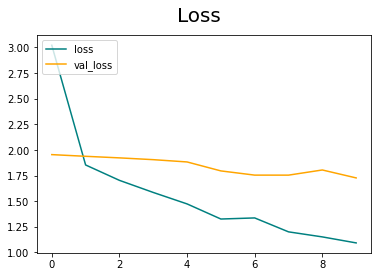

In [59]:
fig = plt.figure()

plt.plot(history5.history['loss'], color='teal', label='loss')
plt.plot(history5.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

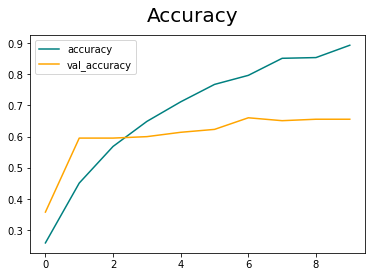

In [63]:
fig = plt.figure()

plt.plot(history5.history['accuracy'], color='teal', label='accuracy')
plt.plot(history5.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**Maybe things got better a little bit, but the overfitting problem is still there. All these regularization techniques didn't help a lot. Maybe the most significant regularization technique that affected our model the most is dropout.(model3).So maybe it is time to try data augmentation and see what happens!!**

## Data Augmentation

In [80]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    )

for directory in os.listdir(train_dataset_directory):
    dataset = []
    for i, img in enumerate(os.listdir(os.path.join(train_dataset_directory, directory))):
        img_path = os.path.join(train_dataset_directory, directory, img)
        img = cv2.imread(img_path)
        #img = Image.fromarray(img, 'RGB')
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.array(img)
        dataset.append(img)

    x = np.array(dataset)
    i = 0
    for batch in datagen.flow(x, batch_size=16,
                              save_to_dir=os.path.join(train_dataset_directory, directory),
                              save_format='jpg'):
      i += 1
      if i > 4:
        break

In [81]:
train_dataset_directory = 'D:/datayoga/TRAIN'
test_dataset_directory = 'D:/datayoga/TEST'

In [82]:
X_train = []
y_train = []

for i, category in enumerate(classes):
    for img in os.listdir(os.path.join(train_dataset_directory, category)):
        img_path = os.path.join(train_dataset_directory, category, img)
        X_train.append(cv2.resize(cv2.imread(img_path), (IMG_SIZE , IMG_SIZE)))
        y_train.append(i)
X_train = np.asarray(X_train)
y_train = pd.get_dummies(y_train).values

In [83]:
X_train.shape

(1875, 256, 256, 3)

In [84]:
X_test = []
y_test = []

for i, category in enumerate(classes):
    for img in os.listdir(os.path.join(test_dataset_directory, category)):
        img_path = os.path.join(test_dataset_directory, category, img)
        X_test.append(cv2.resize(cv2.imread(img_path), (IMG_SIZE , IMG_SIZE)))
        y_test.append(i)
X_test = np.asarray(X_test)
y_test = pd.get_dummies(y_test).values

In [85]:
X_test.shape

(466, 256, 256, 3)

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
SPLIT_SIZE = 0.2

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = SPLIT_SIZE,
    random_state = 42)

## Let's train our models on augmented data

In [ ]:
history3 = model3.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [es, lr, myCallback()]
)

Epoch 1/10
180/180 [==============================] - 17s 25ms/step - loss: 1.8147 - accuracy: 0.3044 - val_loss: 1.4446 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 2/10
180/180 [==============================] - 3s 15ms/step - loss: 1.2772 - accuracy: 0.4844 - val_loss: 1.1671 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 3/10
180/180 [==============================] - 3s 15ms/step - loss: 0.9439 - accuracy: 0.6456 - val_loss: 1.0530 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/10
180/180 [==============================] - 3s 15ms/step - loss: 0.6345 - accuracy: 0.7721 - val_loss: 0.9964 - val_accuracy: 0.6194 - lr: 0.0010
Epoch 5/10
180/180 [==============================] - 3s 15ms/step - loss: 0.4443 - accuracy: 0.8450 - val_loss: 0.9978 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 6/10
180/180 [==============================] - 3s 17ms/step - loss: 0.2734 - accuracy: 0.9062 - val_loss: 1.1275 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 7/10
179/180 [============================>.] - ETA: 0s -

In [ ]:
history5 = model5.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = 20,
    callbacks = [es, lr, myCallback()]
)

Epoch 1/20
180/180 [==============================] - 7s 21ms/step - loss: 3.1362 - accuracy: 0.2689 - val_loss: 2.1190 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 3s 15ms/step - loss: 1.9662 - accuracy: 0.3843 - val_loss: 1.9751 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 3s 16ms/step - loss: 1.8204 - accuracy: 0.5073 - val_loss: 1.8307 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 3s 17ms/step - loss: 1.7165 - accuracy: 0.5810 - val_loss: 1.9143 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 3s 17ms/step - loss: 1.6252 - accuracy: 0.6428 - val_loss: 1.9539 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - ETA: 0s - loss: 1.5494 - accuracy: 0.7005
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 [==============================] - 3s 16

## Let's add more complexity to our model

In [ ]:
model6 = Sequential()

model6.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model6.add(Dropout(0.3))
model6.add(MaxPooling2D((2,2)))

model6.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model6.add(Dropout(0.3))
model6.add(MaxPooling2D((2,2)))

model6.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model6.add(Dropout(0.3))
model6.add(MaxPooling2D((2,2)))

model6.add(Flatten())
model6.add(Dense(256, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(5, activation='softmax'))

In [ ]:
model6.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [es, lr, myCallback()]
)

Epoch 1/10
  5/180 [..............................] - ETA: 9s - loss: 6.5347 - accuracy: 0.2000

180/180 [==============================] - 11s 49ms/step - loss: 1.7405 - accuracy: 0.2460 - val_loss: 1.5227 - val_accuracy: 0.3583 - lr: 0.0010
Epoch 2/10
180/180 [==============================] - 8s 45ms/step - loss: 1.3617 - accuracy: 0.4385 - val_loss: 1.4335 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 3/10
180/180 [==============================] - 8s 44ms/step - loss: 0.8855 - accuracy: 0.6644 - val_loss: 1.1654 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 4/10
180/180 [==============================] - 8s 44ms/step - loss: 0.4178 - accuracy: 0.8582 - val_loss: 1.0552 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 5/10
180/180 [==============================] - 8s 43ms/step - loss: 0.2044 - accuracy: 0.9354 - val_loss: 1.2216 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 6/10
180/180 [==============================] - 8s 44ms/step - loss: 0.0891 - accuracy: 0.9701 - val_loss: 1.2883 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 7/10
179/180 [============================>.] - ETA: 0s - loss: 0.05

### Let's try diffrent combos of convonlutional and pooling layers

In [ ]:
model7 = Sequential()

model7.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model7.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model7.add(MaxPooling2D((2,2)))

model7.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model7.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model7.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model7.add(MaxPooling2D((2,2)))

model7.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model7.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model7.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model7.add(MaxPooling2D((2,2)))

model7.add(Flatten())
model7.add(Dense(256, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(5, activation='softmax'))

In [ ]:
model7.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history7 = model7.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [es, lr, myCallback()]
)

***Seems like adding more complexity to our model is not giving any performance boost, In contrast it adds more overfitting. So we will just stop adding layers to our model and focus more on tuning parameters next in the hyperparameter tuning phase.***

# Testing

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
y_pred = model1.predict(X_test)

15/15 [==============================] - 1s 27ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[55, 11,  1,  9,  0],
       [34, 62,  2,  7,  4],
       [ 4,  4, 71, 18,  0],
       [ 8,  8,  9, 88,  1],
       [ 2,  3,  1,  0, 61]])

In [ ]:
print(metrics.classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

     goddess       0.53      0.72      0.61        76
    warrior2       0.70      0.57      0.63       109
     downdog       0.85      0.73      0.78        97
       plank       0.72      0.77      0.75       114
        tree       0.92      0.91      0.92        67

    accuracy                           0.73       463
   macro avg       0.75      0.74      0.74       463
weighted avg       0.74      0.73      0.73       463



In [ ]:
y_pred = model2.predict(X_test)

15/15 [==============================] - 0s 16ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[53, 13,  5,  5,  0],
       [33, 64, 10,  2,  0],
       [ 2,  3, 81, 11,  0],
       [ 5,  7,  9, 93,  0],
       [ 2,  6,  1,  1, 57]])

In [ ]:
print(metrics.classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

     goddess       0.56      0.70      0.62        76
    warrior2       0.69      0.59      0.63       109
     downdog       0.76      0.84      0.80        97
       plank       0.83      0.82      0.82       114
        tree       1.00      0.85      0.92        67

    accuracy                           0.75       463
   macro avg       0.77      0.76      0.76       463
weighted avg       0.76      0.75      0.75       463



In [ ]:
y_pred = model3.predict(X_test)

15/15 [==============================] - 0s 16ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[46, 13,  7,  6,  4],
       [11, 89,  6,  3,  0],
       [ 1,  6, 74, 14,  2],
       [ 5,  3, 11, 94,  1],
       [ 1,  3,  2,  0, 61]])

In [ ]:
print(metrics.classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

     goddess       0.72      0.61      0.66        76
    warrior2       0.78      0.82      0.80       109
     downdog       0.74      0.76      0.75        97
       plank       0.80      0.82      0.81       114
        tree       0.90      0.91      0.90        67

    accuracy                           0.79       463
   macro avg       0.79      0.78      0.78       463
weighted avg       0.78      0.79      0.78       463



In [ ]:
y_pred = model4.predict(X_test)

15/15 [==============================] - 0s 19ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[36,  4, 23,  8,  5],
       [29, 34, 26, 15,  5],
       [ 0,  1, 71, 23,  2],
       [ 3,  4, 28, 74,  5],
       [ 0,  6,  7,  4, 50]])

In [ ]:
print(metrics.classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

     goddess       0.53      0.47      0.50        76
    warrior2       0.69      0.31      0.43       109
     downdog       0.46      0.73      0.56        97
       plank       0.60      0.65      0.62       114
        tree       0.75      0.75      0.75        67

    accuracy                           0.57       463
   macro avg       0.60      0.58      0.57       463
weighted avg       0.60      0.57      0.56       463



In [ ]:
y_pred = model5.predict(X_test)

15/15 [==============================] - 1s 45ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
print(metrics.classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

     goddess       0.86      0.32      0.46        76
    warrior2       0.69      0.85      0.76       109
     downdog       0.74      0.77      0.76        97
       plank       0.72      0.89      0.80       114
        tree       0.95      0.81      0.87        67

    accuracy                           0.75       463
   macro avg       0.79      0.73      0.73       463
weighted avg       0.77      0.75      0.74       463



## HyperParameter Tuning

## Hyperparameter tuning for learning rate and momentum

In [ ]:
from tensorflow.keras.optimizers import SGD

In [ ]:
def build_model(learning_rate=0.01, momentum=0.1):
  model = Sequential()

  model.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D())

  model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  
  model.compile(optimizer= SGD(lr=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
BATCH_SIZE = 8
EPOCHS = 10

In [ ]:
model = KerasClassifier(build_fn=build_model,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1)

<ipython-input-86-8babcf4626d1>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model,


In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]
momentum = [0.3, 0.5, 0.7, 0.9]

In [ ]:
param_grid = dict(learning_rate=learning_rate, momentum=momentum)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_score_, grid_result.best_params_)

## Hyperparameter tuning for activation function, optimizer and weight initialization

In [ ]:
def build_model(activation = 'relu', init_weights='uniform', optimizer='Adam'):
  model = Sequential()

  model.add(Conv2D(8, (3,3), padding='same', activation=activation, kernel_initializer=init_weights, input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D())

  model.add(Conv2D(16, (3,3), padding='same', activation=activation, kernel_initializer=init_weights))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3,3), padding='same', activation=activation, kernel_initializer=init_weights))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(256, activation='relu', kernel_initialize=init_weights))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
activation=['softmax', 'relu', 'tanh', 'sigmoid']
init_weights=['uniform', 'normal', 'he_uniform', 'he_normal']
optimizer=['SGD', 'RMSprop', 'Adam']

In [ ]:
param_grid = dict(activation=activation, init_weights=init_weights, optimizer=optimizer)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_score_, grid_result.best_params_)

 ## Hyperparameter tuning for dropout rate, number of neurons, batch size, number of epochs

In [ ]:
def build_model(dropout_rate = 0.0, neurons=16):
  model = Sequential()

  model.add(Conv2D(8, (3,3), padding='same', activation=activation, kernel_initializer=init_weights, input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(Dropout(dropout_rate))
  model.add(MaxPooling2D())

  model.add(Conv2D(16, (3,3), padding='same', activation=activation, kernel_initializer=init_weights))
  model.add(Dropout(dropout_rate))
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3,3), padding='same', activation=activation, kernel_initializer=init_weights))
  model.add(Dropout(dropout_rate))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(neurons, activation='relu', kernel_initialize=init_weights))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
dropout_rate = [0.0, 0.2, 0.3, 0.5]
neurons = [32, 64, 128, 256]
batch_size = [8, 16, 32, 64]
epochs = [1, 5, 10, 20]

In [ ]:
param_grid = dict(dropout_rate=dropout_rate, neurons=neurons, batch_size=batch_size, epochs=epochs)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_score_, grid_result.best_params_)